# Anomaly Detection on Financial Time Series

"Financial time-series anomaly detection" refers to the process of identifying unusual data points or patterns within a financial time series, like stock prices or trading volumes, that deviate significantly from the expected behavior, potentially signaling potential market irregularities, fraudulent activity, or other important events that require further investigation

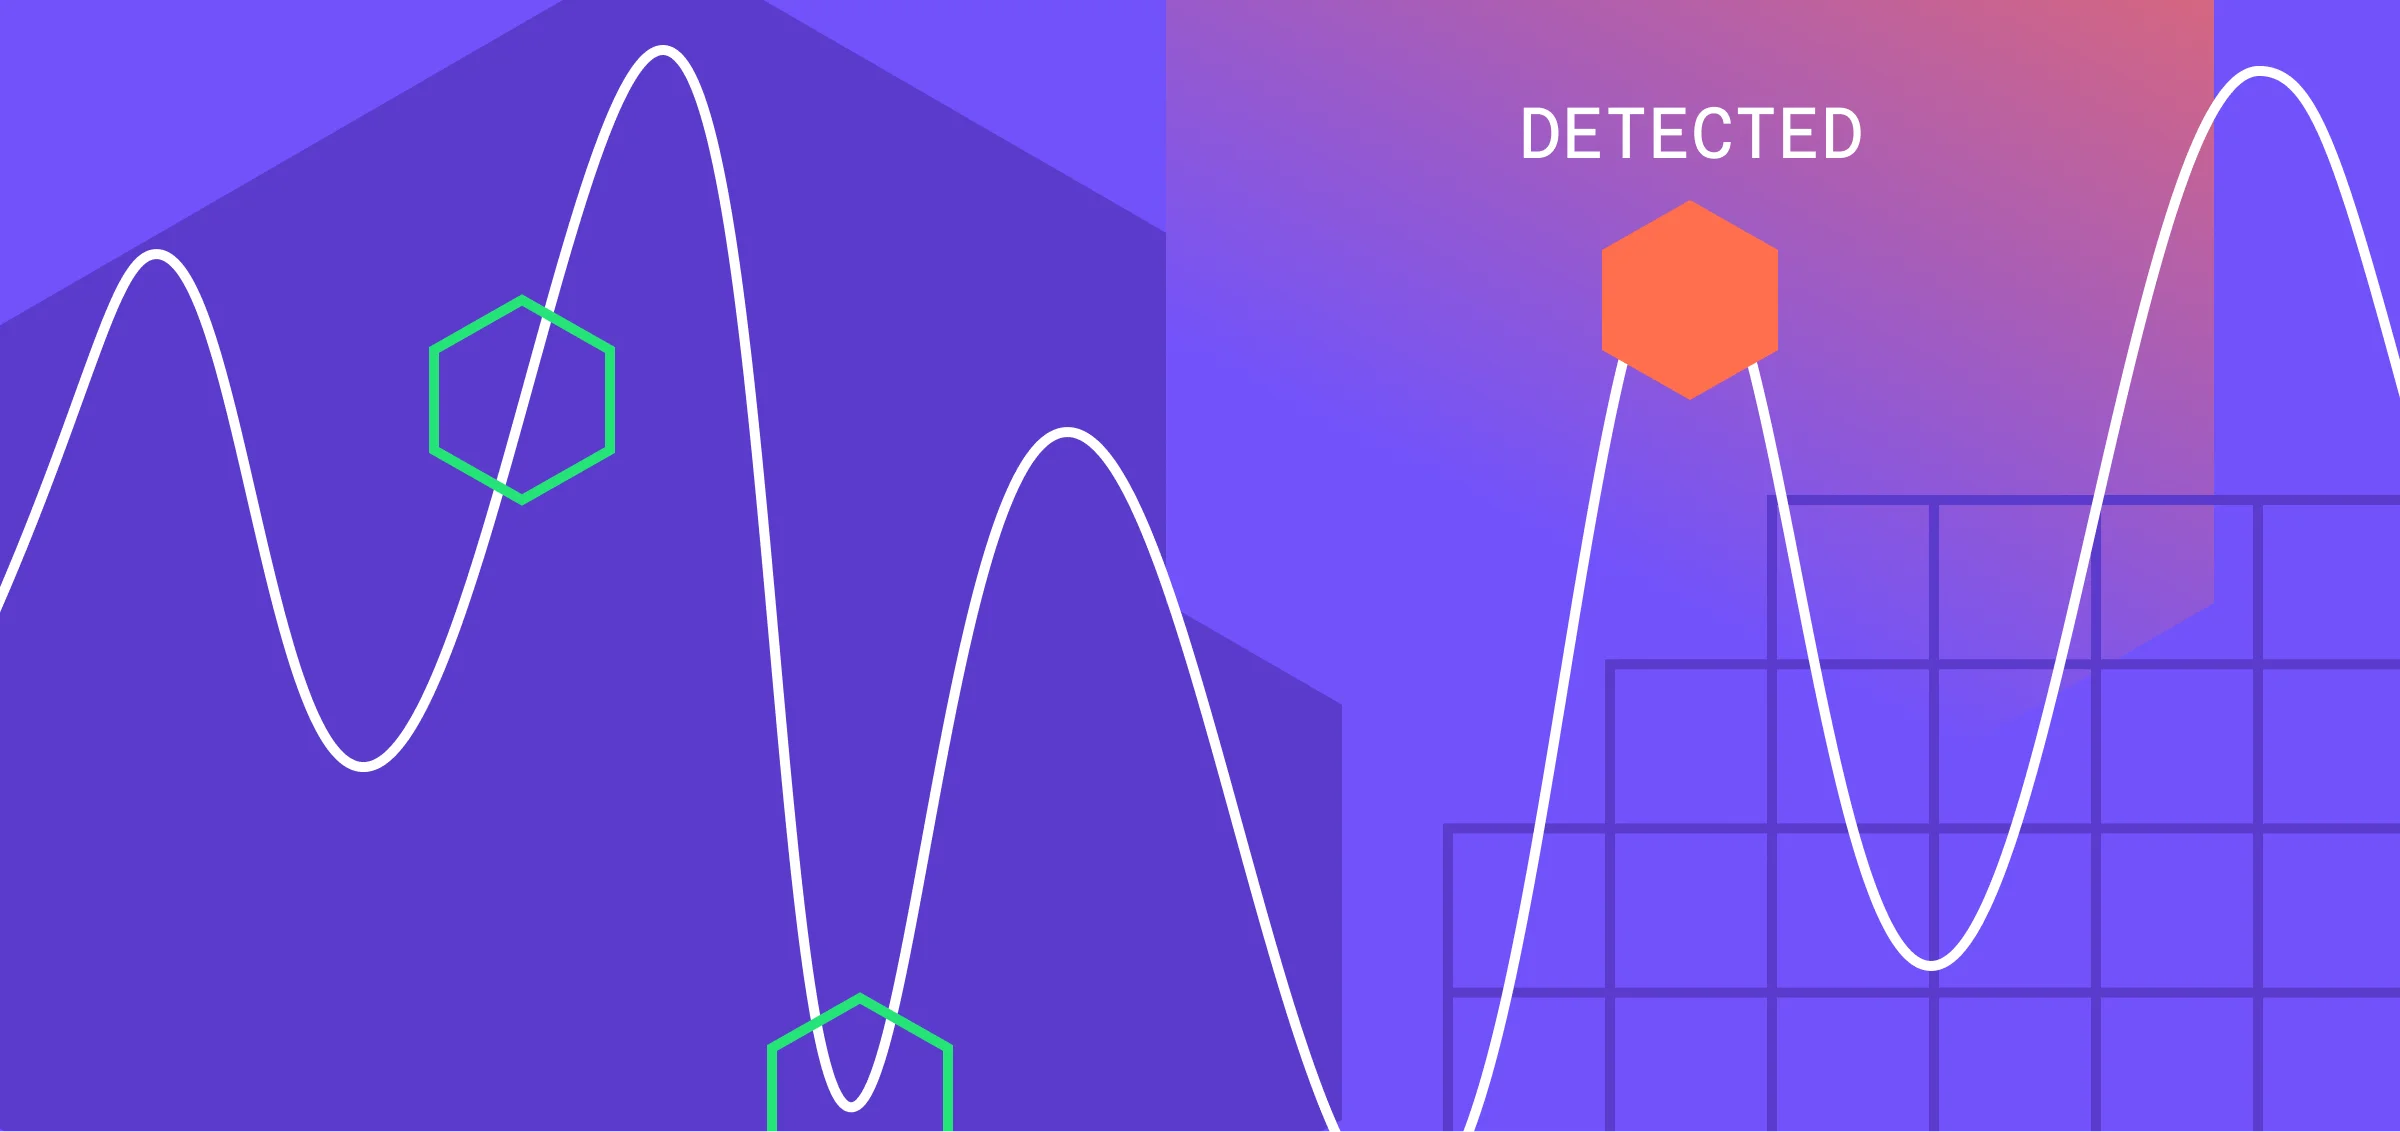


Anomaly detection in time-series data is a critical task in various domains, including finance, healthcare and manufacturing. In the financial sector, detecting anomalies can help identify unusual market behavior, such as sudden price spikes or drops, which may indicate potential opportunities or risks. This tutorial will focus on using Python to detect anomalies in financial time-series data, specifically stock prices.

We will use the yfinance library to download real financial data and implement an anomaly detection system using various techniques. By the end of this tutorial, you will have a solid understanding of how to detect anomalies in time-series data and how to apply these techniques to real-world financial data.


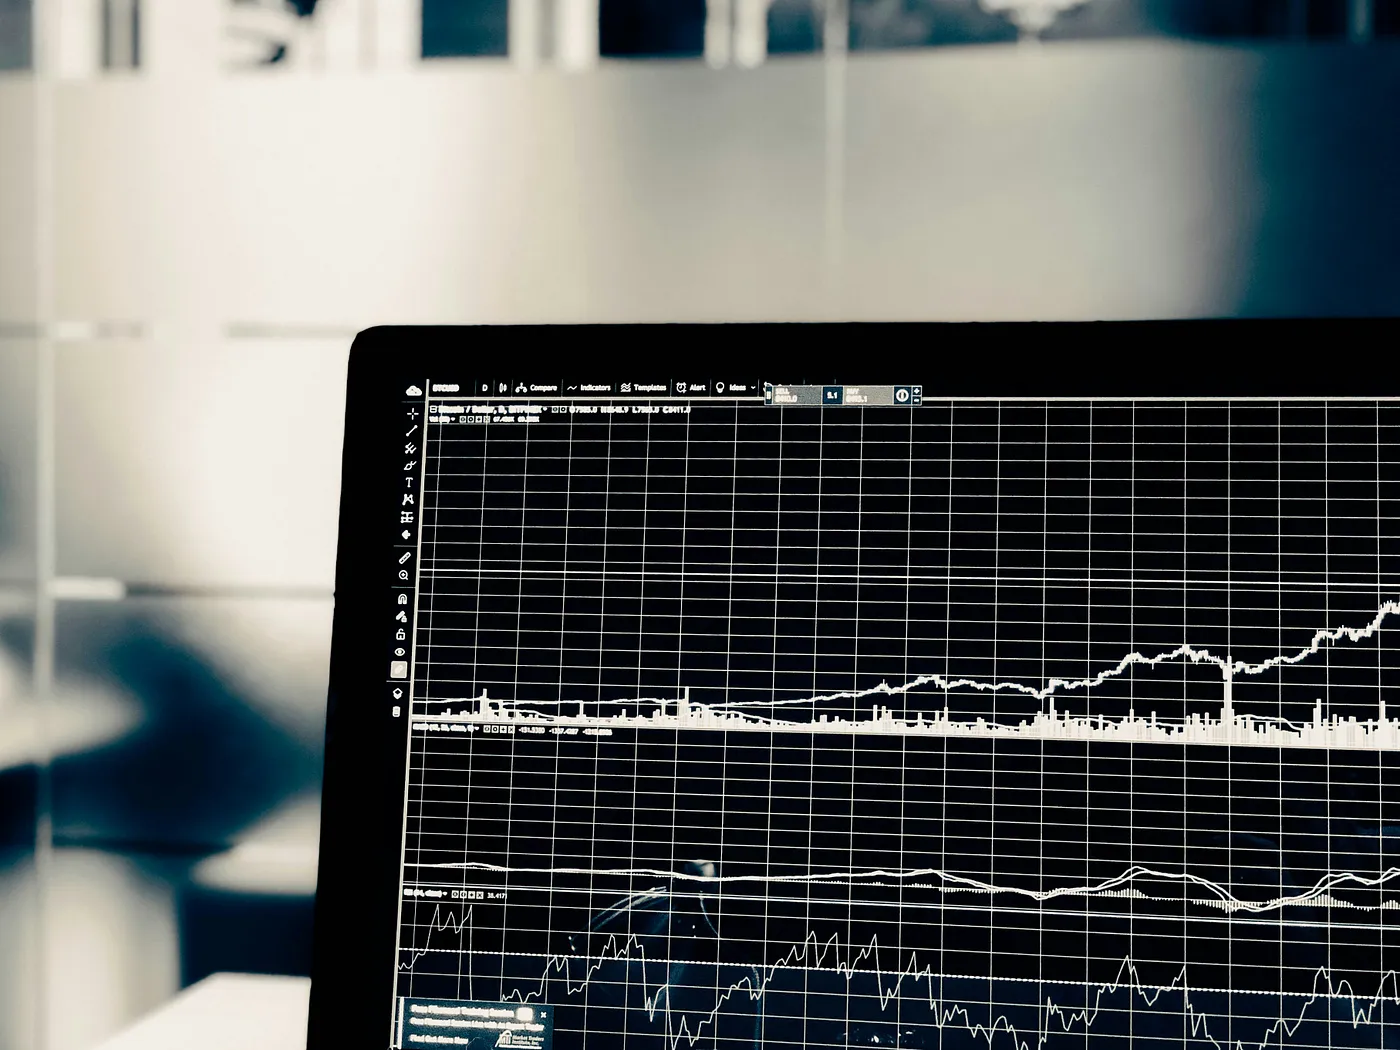

# Download and Preprocess Stock Data
We will use the yfinance library to fetch historical stock price data.

Subtasks:
✅ Install and import necessary libraries
✅ Download stock data for a selected company (e.g., Apple - AAPL)
✅ Convert the date column to a proper datetime format
✅ Handle missing values

In [ ]:
!pip install yfinance


# import Libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose

# Download the data

In [ ]:
# Define the stock symbol and period
ticker = "AAPL"  # Apple Inc.
start_date = "2020-01-01"
end_date = "2024-01-01"

# Download stock data
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Show the header of Dataset

In [ ]:
# Display the first few rows
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.796028,72.856621,71.545395,71.799881,135480400
2020-01-03,72.088287,72.851753,71.862884,72.020424,146322800
2020-01-06,72.662704,72.701485,70.953995,71.206062,118387200
2020-01-07,72.320976,72.929322,72.100418,72.672409,108872000
2020-01-08,73.484337,73.787300,72.022843,72.022843,132079200


# Preprocessing the Data
✅ Subtasks:

Convert the index (Date) to a proper datetime format
Handle missing values (if any)
Keep only the relevant columns (Close, Open, High, Low, Volume)

In [ ]:
# Convert index to datetime format (if not already)
df.index = pd.to_datetime(df.index)

# Handle missing values by forward filling
df.fillna(method='ffill', inplace=True)

# Select relevant columns
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Display dataset info
df.info()

# Show first few rows
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2020-01-02 to 2023-12-29
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Open, AAPL)    1006 non-null   float64
 1   (High, AAPL)    1006 non-null   float64
 2   (Low, AAPL)     1006 non-null   float64
 3   (Close, AAPL)   1006 non-null   float64
 4   (Volume, AAPL)  1006 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 47.2 KB


<ipython-input-63-08cbe6e860f9>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Price,Open,High,Low,Close,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,71.799881,72.856621,71.545395,72.796028,135480400
2020-01-03,72.020424,72.851753,71.862884,72.088287,146322800
2020-01-06,71.206062,72.701485,70.953995,72.662704,118387200
2020-01-07,72.672409,72.929322,72.100418,72.320976,108872000
2020-01-08,72.022843,73.787300,72.022843,73.484337,132079200


# Calculate Financial Indicators
We will compute the following indicators:

✅ Simple Moving Average (SMA) – Average closing price over a set period.

✅ Exponential Moving Average (EMA) – Weighted moving average giving more

importance to recent prices.

✅ Relative Strength Index (RSI) – Measures price momentum to identify

overbought/oversold conditions.

✅ Bollinger Bands – Helps detect volatility by using standard deviations around the SMA.



In [ ]:
# Simple Moving Average (SMA)
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Exponential Moving Average (EMA)
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Standard deviation for Bollinger Bands
df['STD_20'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

# Relative Strength Index (RSI)
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Show first few rows
df.head()


Price,Open,High,Low,Close,Volume,SMA_20,EMA_20,STD_20,Upper_Band,Lower_Band,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2020-01-02,71.799881,72.856621,71.545395,72.796028,135480400,NaN,72.796028,NaN,NaN,NaN,NaN
2020-01-03,72.020424,72.851753,71.862884,72.088287,146322800,NaN,72.728624,NaN,NaN,NaN,NaN
2020-01-06,71.206062,72.701485,70.953995,72.662704,118387200,NaN,72.722346,NaN,NaN,NaN,NaN
2020-01-07,72.672409,72.929322,72.100418,72.320976,108872000,NaN,72.684120,NaN,NaN,NaN,NaN
2020-01-08,72.022843,73.787300,72.022843,73.484337,132079200,NaN,72.760332,NaN,NaN,NaN,NaN


In [ ]:
df.columns = ['_'.join(col).strip('_') for col in df.columns]


# Detect Anomalies with Isolation Forest
We will use Isolation Forest, an unsupervised learning algorithm that identifies anomalies by isolating them from the rest of the data.

In [ ]:
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection
features = ['Close_AAPL', 'SMA_20', 'EMA_20', 'RSI', 'Upper_Band', 'Lower_Band']
df_filtered = df.dropna(subset=features)


# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_filtered['Anomaly'] = iso_forest.fit_predict(df_filtered[features])

# Convert anomaly labels (-1 = anomaly, 1 = normal) to binary (1 = anomaly, 0 = normal)
df_filtered['Anomaly'] = df_filtered['Anomaly'].apply(lambda x: 1 if x == -1 else 0)

# Merge back with original DataFrame
df['Anomaly'] = df_filtered['Anomaly']

# Show anomalies
df[df['Anomaly'] == 1].head()


<ipython-input-70-aae9a518844c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Anomaly'] = iso_forest.fit_predict(df_filtered[features])
<ipython-input-70-aae9a518844c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Anomaly'] = df_filtered['Anomaly'].apply(lambda x: 1 if x == -1 else 0)


,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Volume_AAPL,SMA_20,EMA_20,STD_20,Upper_Band,Lower_Band,RSI,Anomaly
Date,,,,,,,,,,,,
2020-03-23,55.411085,55.513122,51.652713,54.509754,336752800,65.518848,64.652764,5.800534,77.119917,53.917780,34.602418,1.0
2020-04-01,59.886154,60.425494,58.095644,58.528088,176218400,62.240417,62.640378,4.652147,71.544711,52.936122,47.885612,1.0
2020-04-02,58.389610,59.558179,57.553875,59.504730,165934000,61.657469,62.341745,4.181851,70.021170,53.293768,38.790903,1.0
2020-04-03,58.987257,59.691799,58.056774,58.649563,129880000,61.079015,61.990109,3.708676,68.496366,53.661664,49.652614,1.0
2020-04-06,60.955121,63.921488,60.585846,63.766006,201820400,61.034070,62.159242,3.668157,68.370385,53.697755,53.827177,1.0


In [ ]:
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection
features = ['Close_AAPL', 'SMA_20', 'EMA_20', 'RSI', 'Upper_Band', 'Lower_Band']

# Drop NaN values for selected features
df_filtered = df.dropna(subset=features)

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df_filtered['Anomaly'] = iso_forest.fit_predict(df_filtered[features])  # -1 = anomaly, 1 = normal

# Display sample results
df_filtered.head()


<ipython-input-74-ad3e98d94d8d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Anomaly'] = iso_forest.fit_predict(df_filtered[features])  # -1 = anomaly, 1 = normal


,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Volume_AAPL,SMA_20,EMA_20,STD_20,Upper_Band,Lower_Band,RSI,Anomaly
Date,,,,,,,,,,,,
2020-01-30,77.689476,78.549889,77.255630,78.496567,126743200,75.628481,76.003068,2.027574,79.683628,71.573333,63.879216,1
2020-01-31,77.784013,78.208161,74.720451,75.016144,199588400,75.739486,75.909075,1.922386,79.584258,71.894715,49.368880,1
2020-02-03,73.753395,75.980782,73.249267,74.810135,173788400,75.875579,75.804414,1.737781,79.351141,72.400016,42.987529,1
2020-02-04,76.421898,77.471367,76.014717,77.279892,136616400,76.106438,75.944936,1.588800,79.284037,72.928839,54.739736,1
2020-02-05,78.411751,78.712296,77.304123,77.910049,118826800,76.385892,76.132090,1.363486,79.112864,73.658919,57.618751,1


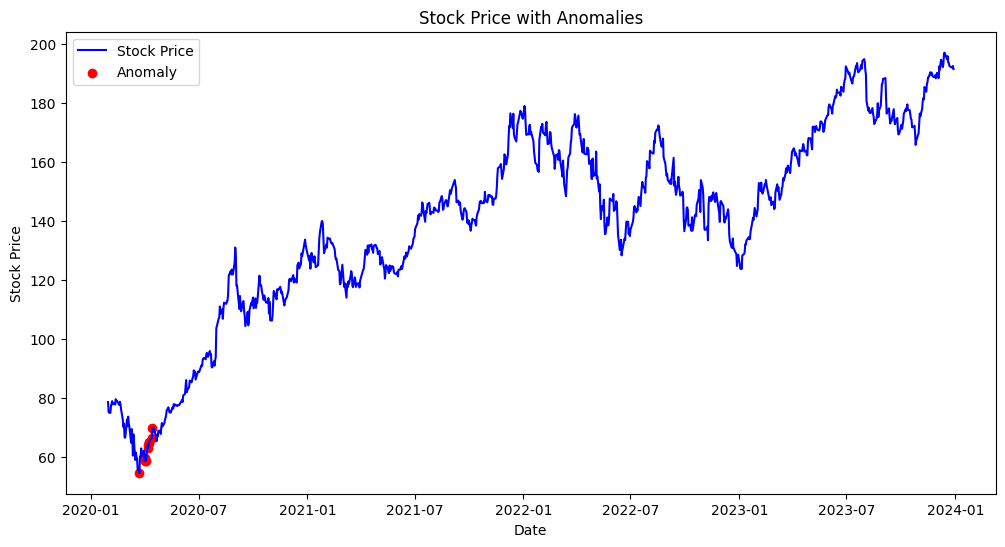

In [ ]:
import matplotlib.pyplot as plt

# Plot stock prices
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered['Close_AAPL'], label='Stock Price', color='blue')

# Highlight anomalies
anomaly_points = df_filtered[df_filtered['Anomaly'] == -1]  # -1 indicates an anomaly
plt.scatter(anomaly_points.index, anomaly_points['Close_AAPL'], color='red', label='Anomaly', marker='o')

# Labels and legend
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price with Anomalies')
plt.legend()
plt.show()


#  Anomaly Detection with DBSCAN
DBSCAN is another unsupervised learning algorithm that detects anomalies by finding points that are in low-density regions (outliers).

Steps:
Prepare the Data: Use the same features as Isolation Forest (Close, SMA_20, EMA_20, RSI, Upper_Band, Lower_Band).
Scale the Data: DBSCAN is sensitive to scale, so we will normalize the data.
Apply DBSCAN Algorithm: Identify anomalies.
Visualize the Results: Plot anomalies on the stock price trend.

# Install & Import DBSCAN
Run this first:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN


# Scale the Data
DBSCAN is sensitive to distances, so we need to normalize the selected features.

Run this:

In [ ]:
# Assuming df is your DataFrame
print(df.head())  # Check the first few rows
print(df.info())  # Check data types and missing values
print(df.isnull().sum())  # Count missing values


            Open_AAPL  High_AAPL   Low_AAPL  Close_AAPL  Volume_AAPL  SMA_20  \
Date                                                                           
2020-01-02  71.799881  72.856621  71.545395   72.796028    135480400     NaN   
2020-01-03  72.020424  72.851753  71.862884   72.088287    146322800     NaN   
2020-01-06  71.206062  72.701485  70.953995   72.662704    118387200     NaN   
2020-01-07  72.672409  72.929322  72.100418   72.320976    108872000     NaN   
2020-01-08  72.022843  73.787300  72.022843   73.484337    132079200     NaN   

               EMA_20  STD_20  Upper_Band  Lower_Band  RSI  Anomaly  
Date                                                                 
2020-01-02  72.796028     NaN         NaN         NaN  NaN      NaN  
2020-01-03  72.728624     NaN         NaN         NaN  NaN      NaN  
2020-01-06  72.722346     NaN         NaN         NaN  NaN      NaN  
2020-01-07  72.684120     NaN         NaN         NaN  NaN      NaN  
2020-01-08  72.7603

In [ ]:
df['SMA_20'].fillna(method='bfill', inplace=True)  # Backward fill
df['STD_20'].fillna(method='bfill', inplace=True)
df['Upper_Band'].fillna(method='bfill', inplace=True)
df['Lower_Band'].fillna(method='bfill', inplace=True)
df['RSI'].fillna(df['RSI'].mean(), inplace=True)  # Fill RSI with mean


In [ ]:
features = ['Close_AAPL', 'SMA_20', 'EMA_20', 'RSI', 'Upper_Band', 'Lower_Band']
df_filtered = df[features].dropna()  # Drop NaNs again if any remain


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_filtered)


In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.5, min_samples=5)  # Try different values for eps
labels = dbscan.fit_predict(df_scaled)
df_filtered['Anomaly_DBSCAN'] = labels


In [ ]:
features = ['Close_AAPL', 'SMA_20', 'EMA_20', 'RSI', 'Upper_Band', 'Lower_Band', 'Volume_AAPL']
df_filtered = df[features].dropna()
df_scaled = scaler.fit_transform(df_filtered)


In [ ]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust contamination rate
anomaly_scores = lof.fit_predict(df_scaled)
df_filtered['Anomaly_LOF'] = anomaly_scores

num_anomalies_lof = (df_filtered['Anomaly_LOF'] == -1).sum()
print(f"Total number of anomalies detected (LOF): {num_anomalies_lof}")


Total number of anomalies detected (LOF): 50


# Visualize DBSCAN Anomalies

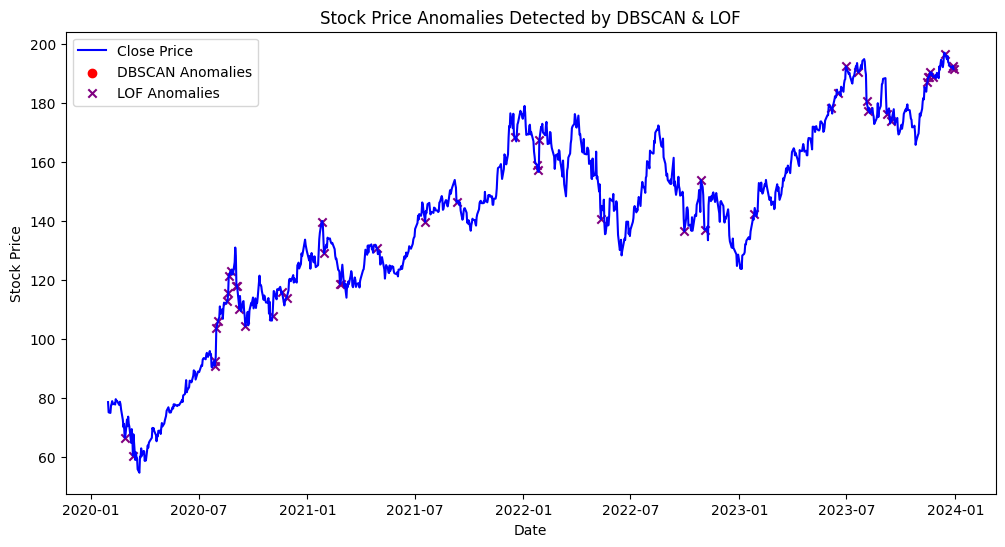

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_filtered.index, df_filtered['Close_AAPL'], label='Close Price', color='blue')
plt.scatter(df_filtered.index[df_filtered['Anomaly_DBSCAN'] == -1],
            df_filtered['Close_AAPL'][df_filtered['Anomaly_DBSCAN'] == -1],
            color='red', label='DBSCAN Anomalies', marker='o')
plt.scatter(df_filtered.index[df_filtered['Anomaly_LOF'] == -1],
            df_filtered['Close_AAPL'][df_filtered['Anomaly_LOF'] == -1],
            color='purple', label='LOF Anomalies', marker='x')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Anomalies Detected by DBSCAN & LOF')
plt.show()


In [ ]:
print("Total number of anomalies detected:", (df_filtered['Anomaly_DBSCAN'] == 1).sum())


Total number of anomalies detected: 0


In [ ]:
print(df_filtered['Anomaly_LOF'].value_counts())


Anomaly_LOF
 1    937
-1     50
Name: count, dtype: int64


In [ ]:
print(df_filtered[df_filtered['Anomaly_LOF'] == -1][['Close_AAPL']])


            Close_AAPL
Date                  
2020-02-28   66.411659
2020-03-12   60.306454
2020-07-28   90.866524
2020-07-29   92.608299
2020-07-31  103.541222
2020-08-03  106.150223
2020-08-18  112.808746
2020-08-20  115.456604
2020-08-21  121.406372
2020-08-24  122.858421
2020-09-03  117.999535
2020-09-04  118.077621
2020-09-08  110.131607
2020-09-18  104.294075
2020-11-03  107.808311
2020-11-19  116.012711
2020-11-27  114.008110
2021-01-25  139.755005
2021-01-29  129.037735
2021-02-25  118.487480
2021-02-26  118.751869
2021-04-29  130.719101
2021-07-19  139.740540
2021-09-10  146.355515
2021-12-17  168.381790
2022-01-24  159.015213
2022-01-25  157.204880
2022-01-28  167.584839
2022-05-12  140.647430
2022-09-30  136.535324
2022-10-28  153.864044
2022-11-04  136.939941
2023-01-26  142.461914
2023-06-05  178.228714
2023-06-16  183.528534
2023-06-30  192.510452
2023-07-21  190.495728
2023-08-04  180.620575
2023-08-07  177.504227
2023-09-07  176.461899
2023-09-15  173.927643
2023-11-15 

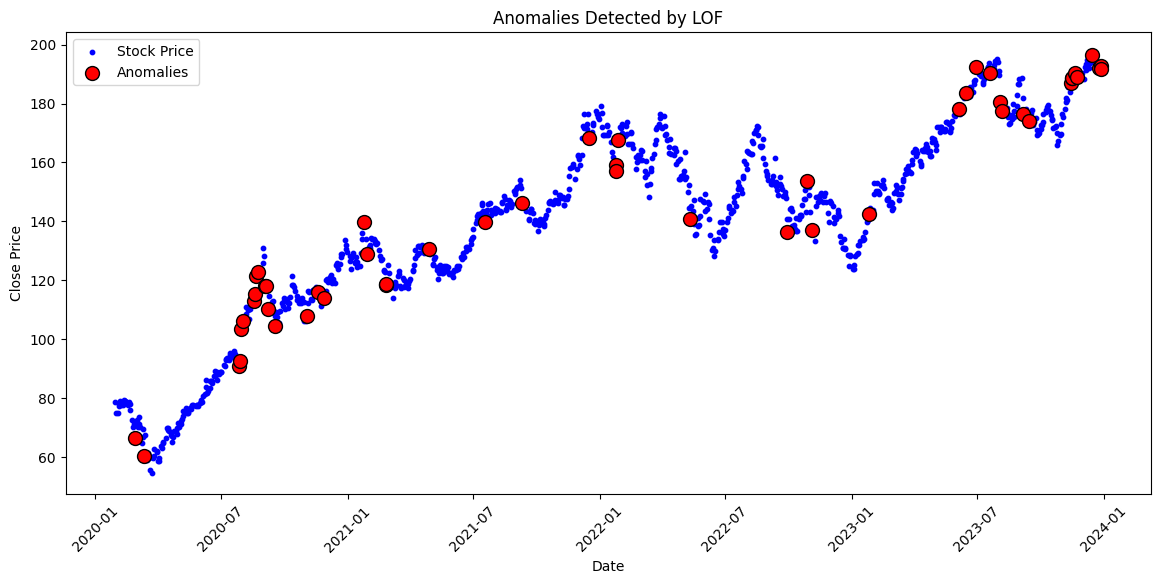

In [ ]:
plt.figure(figsize=(14,6))

# Plot normal stock prices in blue
plt.scatter(df_filtered.index, df_filtered['Close_AAPL'], label='Stock Price', color='blue', s=10)

# Plot anomalies in red (bigger, more visible)
plt.scatter(df_filtered[df_filtered['Anomaly_LOF'] == -1].index,
            df_filtered[df_filtered['Anomaly_LOF'] == -1]['Close_AAPL'],
            color='red', label='Anomalies', s=100, marker='o', edgecolors='black')

plt.legend()
plt.title('Anomalies Detected by LOF')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()


Anomaly_DBSCAN
0    987
Name: count, dtype: int64


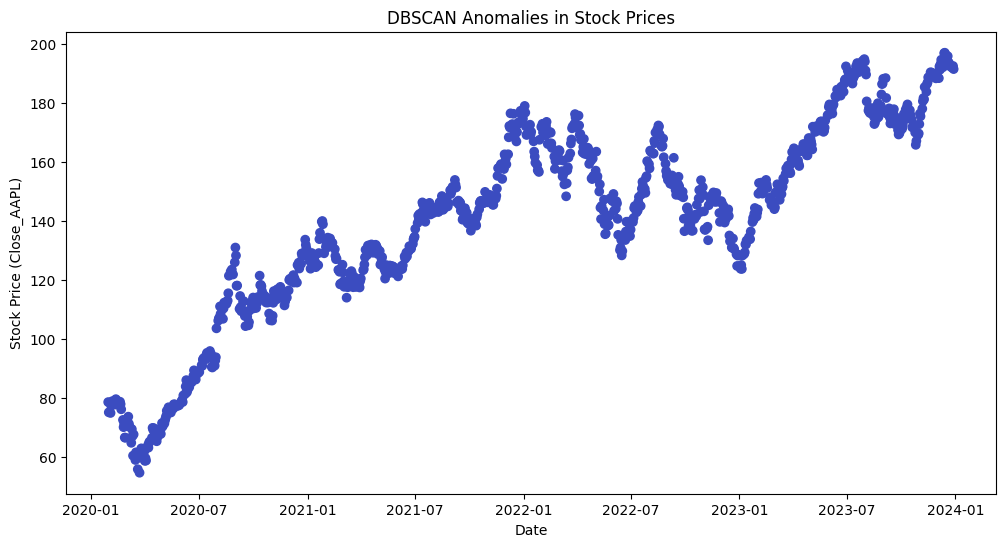

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Select relevant features
features = ['Close_AAPL', 'Volume_AAPL', 'SMA_20', 'RSI']
df_filtered = df[features].dropna()  # Remove NaN values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Adjust parameters if needed
df_filtered['Anomaly_DBSCAN'] = dbscan.fit_predict(X_scaled)

# Count anomalies (-1 indicates anomaly)
print(df_filtered['Anomaly_DBSCAN'].value_counts())

# Plot anomalies
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.scatter(df_filtered.index, df_filtered['Close_AAPL'], c=df_filtered['Anomaly_DBSCAN'], cmap='coolwarm')
plt.title('DBSCAN Anomalies in Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price (Close_AAPL)')
plt.show()


# Starting with Prophet

 Install & Import Required Libraries

In [ ]:
!pip install prophet
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


# Prepare Data for Prophet
Prophet requires two columns only:

ds: Date (timestamp).
y: Stock closing price.

In [ ]:
# Select necessary columns for Prophet
df_prophet = df_filtered[['Close_AAPL']].reset_index()
df_prophet.rename(columns={'Date': 'ds', 'Close_AAPL': 'y'}, inplace=True)

# Display first few rows
print(df_prophet.head())


          ds          y
0 2020-01-30  78.496567
1 2020-01-31  75.016144
2 2020-02-03  74.810135
3 2020-02-04  77.279892
4 2020-02-05  77.910049


# Train the Prophet Model

In [ ]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet()

# Fit the model on data
model.fit(df_prophet)

# Define future dates for forecasting
future = model.make_future_dataframe(periods=365)  # Forecast for next 1 year

# Predict
forecast = model.predict(future)

# Show predictions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubvcwsxd/fqb4imq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpubvcwsxd/biyc63y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93649', 'data', 'file=/tmp/tmpubvcwsxd/fqb4imq2.json', 'init=/tmp/tmpubvcwsxd/biyc63y0.json', 'output', 'file=/tmp/tmpubvcwsxd/prophet_modelso4mfmvi/prophet_model-20250210174741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:47:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1347,2024-12-24,240.765109,201.370388,285.785915
1348,2024-12-25,240.855511,201.734556,287.210812
1349,2024-12-26,240.703775,201.780606,288.494185
1350,2024-12-27,240.606168,199.608636,287.638501
1351,2024-12-28,249.645759,207.897645,295.465141


# Plot the Forecast 📈
Run this to visualize the predicted stock price trend:

In [ ]:
from prophet.plot import plot_plotly
import plotly.graph_objects as go

# Plot forecast
fig = plot_plotly(model, forecast)
fig.show()


# Detect Anomalies 🚨
Now, let's flag anomalies where actual stock prices significantly deviate from predictions.

In [ ]:
import numpy as np

# Merge actual data with predictions
df_merged = df_prophet.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

# Define anomaly condition (outside confidence interval)
df_merged['Anomaly'] = np.where(
    (df_merged['y'] < df_merged['yhat_lower']) | (df_merged['y'] > df_merged['yhat_upper']),
    1, 0
)

# Print anomalies
print("Total Anomalies Detected:", df_merged['Anomaly'].sum())
df_merged[df_merged['Anomaly'] == 1]


Total Anomalies Detected: 202


,ds,y,yhat,yhat_lower,yhat_upper,Anomaly
0,2020-01-30,78.496567,65.643774,56.547239,74.608466,1
1,2020-01-31,75.016144,66.330082,56.980026,74.721140,1
13,2020-02-19,78.622139,68.678628,59.663550,77.938295,1
14,2020-02-20,77.815536,68.011010,58.486881,76.657171,1
15,2020-02-21,76.054192,67.403459,58.117913,76.036497,1
...,...,...,...,...,...,...
941,2023-10-25,170.041870,179.747181,170.099585,188.721684,1
942,2023-10-26,165.857880,179.608224,170.484413,188.476336,1
943,2023-10-27,167.179657,179.565923,170.473614,188.340836,1
944,2023-10-30,169.236847,180.020542,170.823813,188.688215,1


# Visualizing Anomalies on Stock Price Trends 📊
Now, let's plot the actual stock prices and highlight anomalies in red. 🔴

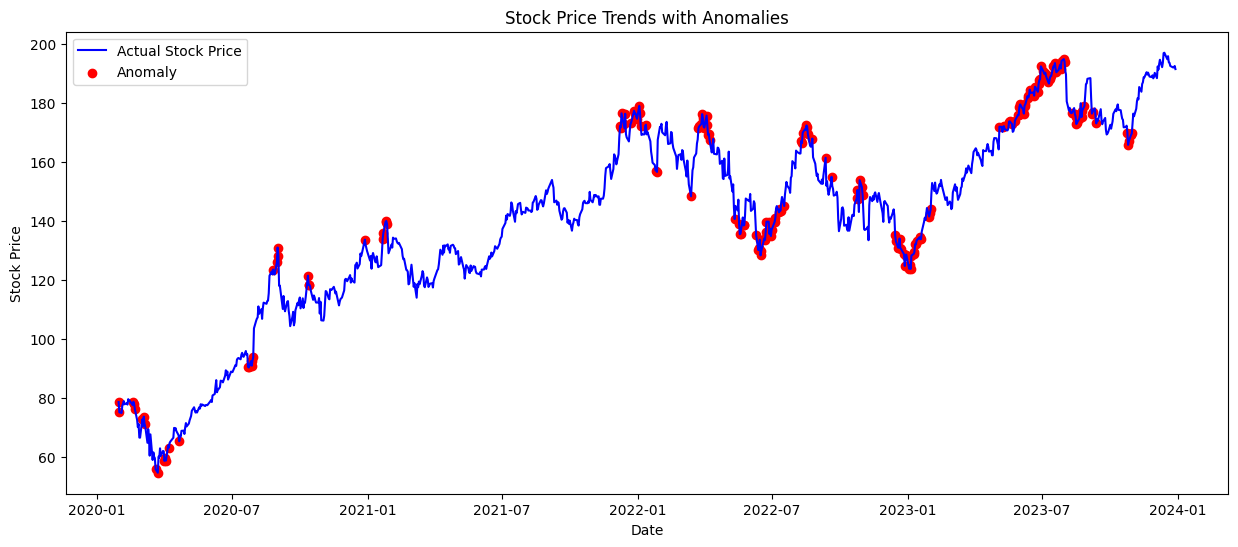

In [ ]:
import matplotlib.pyplot as plt

# Plot actual stock prices
plt.figure(figsize=(15,6))
plt.plot(df_merged['ds'], df_merged['y'], label='Actual Stock Price', color='blue')

# Plot anomalies
anomalies = df_merged[df_merged['Anomaly'] == 1]
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomaly', marker='o')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Trends with Anomalies')
plt.legend()
plt.show()


# Build a Time-Series Forecasting Model using LSTM 🤖📈
Now, we'll train an LSTM (Long Short-Term Memory) model to forecast stock prices and detect future anomalies.

✅ Steps:

Prepare Data: Normalize the data and create time-series sequences.

Build LSTM Model: Define an LSTM-based neural network.

Train the Model: Fit the model on historical stock prices.

Make Predictions: Forecast future stock prices.

Detect Deviations: Compare predicted values with actual values.

# Data Preprocessing for LSTM

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Select only relevant columns
df_lstm = df_merged[['ds', 'y']].copy()
df_lstm['ds'] = pd.to_datetime(df_lstm['ds'])
df_lstm.set_index('ds', inplace=True)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
df_lstm['y'] = scaler.fit_transform(df_lstm[['y']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

# Define sequence length
SEQ_LENGTH = 30  # Using last 30 days to predict next value

# Prepare training data
data_values = df_lstm['y'].values
X_train, y_train = create_sequences(data_values, SEQ_LENGTH)

# Reshape input to match LSTM format (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print("Data Preprocessed Successfully! ✅")


Data Preprocessed Successfully! ✅


# Define & Train the LSTM Model
Now, we'll define an LSTM-based neural network and train it on our dataset.

✅ Steps:

1️⃣ Define an LSTM model with layers.

2️⃣ Compile the model using Mean Squared Error (MSE) loss and Adam optimizer.

3️⃣ Train the model on historical data.

In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, 1)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer (predicting stock price)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

print("LSTM Model Trained Successfully! ✅")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0671 - val_loss: 0.0045
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0

# Get Predictions & Visualize Anomalies

In [ ]:
X_scaled = X_scaled[:957]  # Keep only the first 957 rows


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)

print(f"✅ Data Split Done! X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")


✅ Data Split Done! X_train: (765, 4), X_test: (192, 4), y_train: (765,), y_test: (192,)


In [ ]:
# Get model predictions
test_predictions = model.predict(X_test)

# Reshape predictions if necessary
test_predictions = test_predictions.flatten()  # Ensure it's a 1D array

print(f"✅ Predictions Done! Shape: {test_predictions.shape}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  
✅ Predictions Done! Shape: (192,)


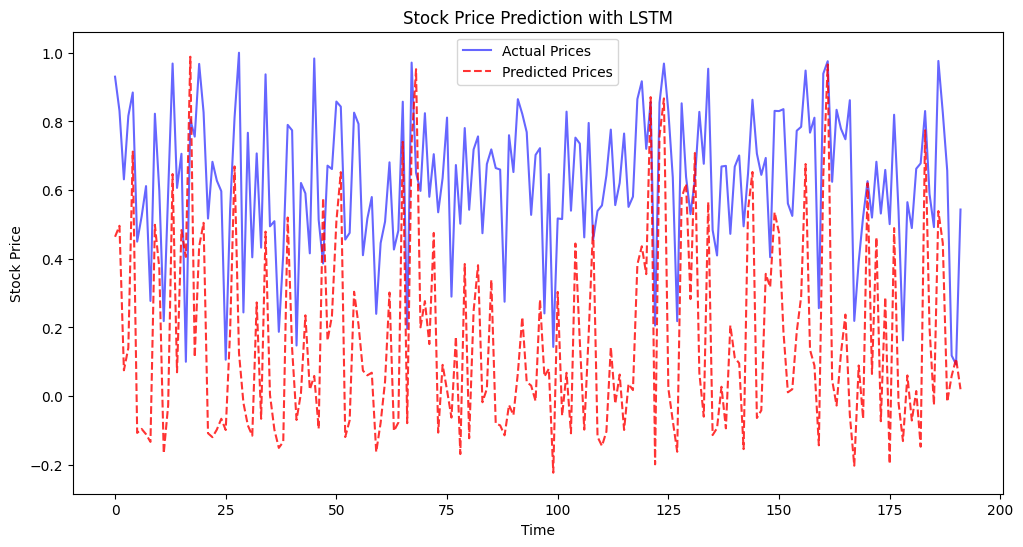

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs. predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color="blue", alpha=0.6)
plt.plot(test_predictions, label="Predicted Prices", color="red", linestyle="dashed", alpha=0.8)
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction with LSTM")
plt.show()


# Identify Anomalies in Predictions
We'll calculate the error (difference between actual and predicted prices) and detect points where the error is significantly high.

# Compute Error & Set Threshold

In [ ]:
import numpy as np

# Calculate absolute errors
errors = np.abs(y_test - test_predictions)

# Set threshold for anomalies (e.g., 2 standard deviations from mean)
threshold = np.mean(errors) + 2 * np.std(errors)

# Identify anomaly points
anomalies = np.where(errors > threshold)[0]

print(f"✅ Anomalies Detected: {len(anomalies)}")


✅ Anomalies Detected: 2


#  Plot Anomalies on Stock Trends

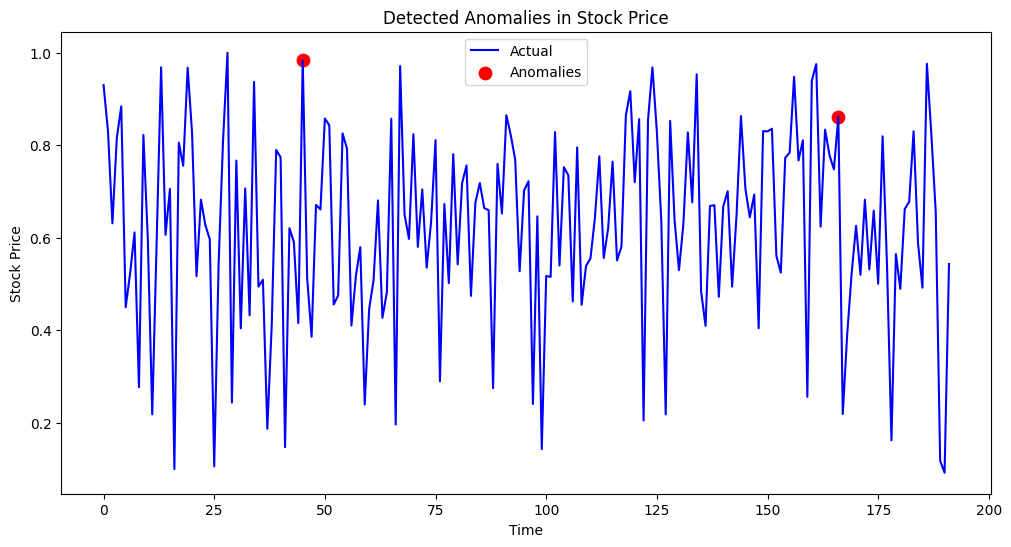

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="blue")

# Mark anomalies with red dots
plt.scatter(anomalies, y_test[anomalies], color="red", label="Anomalies", marker="o", s=80)

plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Detected Anomalies in Stock Price")
plt.legend()
plt.show()
